In [1]:
from dataclasses import dataclass
import json
from pathlib import Path
from typing import Dict, List, Set, Tuple
from collections import defaultdict

@dataclass
class ExperimentConfig:
    depths: List[int]
    hidden_sizes: List[int]
    train_sizes: List[int]
    learning_rates: List[float]

@dataclass
class ResultsData:
    nn_results: List[dict]
    ntk_results: List[dict]
    config: ExperimentConfig
    
    def filter_results(self, model_type: str, **kwargs) -> List[dict]:
        """
        Filter results based on given parameters.
        
        Args:
            model_type: Either 'nn' or 'ntk'
            **kwargs: Key-value pairs to filter on (e.g., depth=2, hidden_size=128)
            
        Returns:
            List of results matching the criteria
        """
        results = self.nn_results if model_type == 'nn' else self.ntk_results
        filtered = []
        
        for result in results:
            matches = True
            for key, value in kwargs.items():
                # Handle learning_rate/lr difference
                if key == 'learning_rate' and 'lr' in result:
                    if result['lr'] != value:
                        matches = False
                        break
                elif result.get(key) != value:
                    matches = False
                    break
            if matches:
                filtered.append(result)
                
        return filtered

class ResultsLoader:
    @staticmethod
    def _load_file(file_path: Path) -> List[dict]:
        """Load a single JSON file, handling empty files and errors."""
        try:
            with open(file_path) as f:
                content = f.read().strip()
                if not content:
                    print(f"Warning: Empty file found - {file_path}")
                    return []
                    
                results = json.loads(content)
                return results if isinstance(results, list) else [results]
                    
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return []

    @staticmethod
    def _extract_config(nn_results: List[dict], ntk_results: List[dict]) -> ExperimentConfig:
        """Extract configuration parameters from results."""
        depths = sorted(set(r['depth'] for r in nn_results))
        hidden_sizes = sorted(set(r['hidden_size'] for r in nn_results))
        train_sizes = sorted(set(r['n_train'] for r in nn_results))
        
        # Handle different learning rate keys
        learning_rates = set()
        for r in nn_results:
            lr = r.get('learning_rate', r.get('lr'))
            if lr is not None:
                learning_rates.add(lr)
        
        return ExperimentConfig(
            depths=depths,
            hidden_sizes=hidden_sizes,
            train_sizes=train_sizes,
            learning_rates=sorted(learning_rates)
        )

    @staticmethod
    def _standardize_result(result: dict, model_type: str) -> dict:
        """Standardize a single result dictionary."""
        result = result.copy()
        
        # Standardize learning rate key
        if 'lr' in result and 'learning_rate' not in result:
            result['learning_rate'] = result['lr']
            del result['lr']
            
        # Add model type
        result['model_type'] = model_type
        
        return result

    @classmethod
    def load_results(cls, nn_results_dir: str, ntk_results_path: str) -> ResultsData:
        """
        Load and preprocess both NN and NTK results into a structured format.
        
        Args:
            nn_results_dir: Directory containing NN result JSON files
            ntk_results_path: Path to the NTK results JSON file
            
        Returns:
            ResultsData object containing preprocessed results and configuration
        """
        # Convert paths
        nn_dir = Path(nn_results_dir)
        ntk_path = Path(ntk_results_path)
        
        # Load NN results
        nn_files = list(nn_dir.glob("results*.json"))
        if not nn_files:
            raise ValueError(f"No result files found in {nn_results_dir}")
        
        nn_results = []
        for file_path in nn_files:
            results = cls._load_file(file_path)
            nn_results.extend(cls._standardize_result(r, 'nn') for r in results)
            
        # Load NTK results
        ntk_results = [
            cls._standardize_result(r, 'ntk') 
            for r in cls._load_file(ntk_path)
        ]
        
        print(f"Loaded {len(nn_results)} NN results and {len(ntk_results)} NTK results")
        
        # Extract configuration
        config = cls._extract_config(nn_results, ntk_results)
        
        # Sort results
        def sort_key(r):
            return (r['depth'], r['hidden_size'], r['n_train'])
            
        nn_results.sort(key=sort_key)
        ntk_results.sort(key=sort_key)
        
        return ResultsData(
            nn_results=nn_results,
            ntk_results=ntk_results,
            config=config
        )


def calculate_statistics(results: List[dict], group_by: str) -> Dict:
    """Calculate basic statistics for results grouped by a key."""
    stats = defaultdict(lambda: {'count': 0, 'sum': 0.0, 'sum_sq': 0.0})
    
    for result in results:
        group = result[group_by]
        error = result['test_error']
        
        stats[group]['count'] += 1
        stats[group]['sum'] += error
        stats[group]['sum_sq'] += error * error
    
    # Calculate mean and std
    formatted_stats = {}
    for group, values in stats.items():
        count = values['count']
        mean = values['sum'] / count
        variance = (values['sum_sq'] / count) - (mean * mean)
        std = variance ** 0.5 if variance > 0 else 0
        
        formatted_stats[group] = {
            'mean': mean,
            'std': std,
            'count': count
        }
    
    return formatted_stats

# Example usage:
def load_and_analyze_results(nn_dir: str, ntk_path: str) -> ResultsData:
    """Example function showing how to use the ResultsLoader."""
    # Load results
    results_data = ResultsLoader.load_results(nn_dir, ntk_path)
    
    # Print configuration summary
    print("\nExperiment Configuration:")
    print(f"Depths: {results_data.config.depths}")
    print(f"Hidden sizes: {results_data.config.hidden_sizes}")
    print(f"Training sizes: {results_data.config.train_sizes}")
    print(f"Learning rates: {results_data.config.learning_rates}")
    
    # Print some basic statistics
    print("\nNN Results Summary:")
    nn_stats = calculate_statistics(results_data.nn_results, 'depth')
    for depth, stats in sorted(nn_stats.items()):
        print(f"Depth {depth}:")
        print(f"  Mean: {stats['mean']:.4f}")
        print(f"  Std:  {stats['std']:.4f}")
        print(f"  Count: {stats['count']}")
    
    print("\nNTK Results Summary:")
    ntk_stats = calculate_statistics(results_data.ntk_results, 'depth')
    for depth, stats in sorted(ntk_stats.items()):
        print(f"Depth {depth}:")
        print(f"  Mean: {stats['mean']:.4f}")
        print(f"  Std:  {stats['std']:.4f}")
        print(f"  Count: {stats['count']}")
    
    return results_data

Loaded 570 NN results and 2346 NTK results


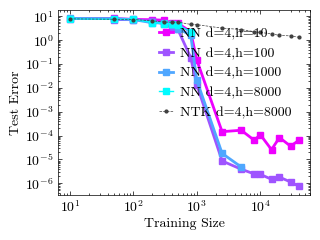

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    greyblack='#404040'
    
    def __init__(self):
        self.setup_science_style()
        
        # Define default color schemes
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'greyblack':self.greyblack
        }
    
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            
            # Font settings
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            
            # Axis settings
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            
            # Tick settings
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            
            # Grid settings
            'grid.linewidth': 0.5,
            
            # Line settings
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            
            # Legend settings
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_training_curves(self,
                           results_data: ResultsData,
                           nn_config: Dict[str, List],
                           ntk_config: Dict[str, List],
                           training_mode: str = 'ntk',
                           nn_styles: Optional[Dict[int, PlotStyle]] = None,
                           ntk_styles: Optional[Dict[int, PlotStyle]] = None,
                           figsize: Optional[Tuple[float, float]] = None) -> plt.Figure:
        """
        Create training curves plot.
        
        Args:
            results_data: ResultsData object
            nn_config: Neural network configuration
            ntk_config: NTK configuration
            training_mode: Mode for kernel training ('ntk', 'nngp', or 'random_limit')
            nn_styles: Dict mapping widths to PlotStyle objects for NN curves
            ntk_styles: Dict mapping widths to PlotStyle objects for NTK curves
            figsize: Optional figure size
        """
        if figsize is None:
            figsize = (3.3, 2.5)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default styles if none provided
        default_nn_style = PlotStyle(
            color=self.colors['blue'], 
            linestyle='-', 
            linewidth=1.0,
            marker='o',
            markersize=3
        )
        default_ntk_style = PlotStyle(
            color=self.colors['purple'], 
            linestyle='-', 
            linewidth=1.0, 
            marker='o', 
            markersize=3
        )
        
        # Plot NN results
        for depth in nn_config['depths']:
            for width in nn_config['widths']:
                style = nn_styles.get(width, default_nn_style) if nn_styles else default_nn_style
                
                for lr in nn_config['learning_rates']:
                    results = results_data.filter_results(
                        'nn', depth=depth, hidden_size=width, learning_rate=lr
                    )
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        label = f'NN d={depth},h={width}'
                        ax.plot(train_sizes, errors, 
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Plot NTK results
        for depth in ntk_config['depths']:
            for width in ntk_config['widths']:
                style = ntk_styles.get(width, default_ntk_style) if ntk_styles else default_ntk_style
                
                results = [r for r in results_data.filter_results('ntk', depth=depth, hidden_size=width)
                          if r.get('training_mode') == training_mode]
                
                if results:
                    sorted_results = sorted(results, key=lambda x: x['n_train'])
                    train_sizes = [r['n_train'] for r in sorted_results]
                    errors = [r['test_error'] for r in sorted_results]
                    label = f'NTK d={depth},h={width}'
                    ax.plot(train_sizes, errors,
                           color=style.color,
                           linestyle=style.linestyle,
                           linewidth=style.linewidth,
                           marker=style.marker,
                           markersize=style.markersize,
                           alpha=style.alpha,
                           label=label)
        
        # Configure log axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel('Training Size', labelpad=2)
        ax.set_ylabel('Test Error', labelpad=2)
        
        # Add legend
        ax.legend(frameon=False, 
                 loc='upper right',
                 bbox_to_anchor=(0.98, 0.98),
                 handlelength=1.0,
                 handletextpad=0.5)
        
        plt.tight_layout()
        return fig


def create_training_plot(
    results_data,
    nn_config: dict,
    ntk_config: dict,
    nn_styles: dict,
    ntk_styles: dict,
    training_mode: str = 'ntk'
):
    """
    Create a training plot with specified configurations and styles.
    
    Args:
        results_data: The loaded results data
        nn_config: Configuration for neural networks
        ntk_config: Configuration for NTK
        nn_styles: Dictionary mapping widths to PlotStyle objects for NN
        ntk_styles: Dictionary mapping widths to PlotStyle objects for NTK
        training_mode: Which kernel training mode to use
    """
    plotter = SciencePlotter()
    
    # Create the plot
    fig = plotter.plot_training_curves(
        results_data,
        nn_config=nn_config,
        ntk_config=ntk_config,
        training_mode=training_mode,
        nn_styles=nn_styles,
        ntk_styles=ntk_styles
    )
    
    return fig

# Usage example:

# Initialize plotter for color access
plotter = SciencePlotter()

#8710ff
#5a47f8
#2d7ef1
#01b5eb

# Define styles
nn_styles = {
    10: PlotStyle(
        color="#ee00ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=5
    ),
    100: PlotStyle(
        color="#9f54ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=5
    ),
    1000: PlotStyle(
        color="#4fa7ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=5
    ),
    8000: PlotStyle(
        color="#00fbff",
        linestyle='-',
        linewidth=1.0,
        marker='s',
        markersize=5
    )
}

ntk_styles = {
    8000: PlotStyle(
        color=plotter.greyblack,
        linestyle='--',
        linewidth=0.5,
        marker='o',
        markersize=2
    )
}

# Define configurations
nn_config = {
    'depths': [4],
    'widths': [10, 100, 1000, 8000],
    'learning_rates': [0.05]
}

ntk_config = {
    'depths': [4],
    'widths': [8000]
}

# Load data
nn_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_1612_nogrokk_mup_pennington"
ntk_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_1812_spectral/final_results_20241219_015151.json"
results_data = ResultsLoader.load_results(nn_dir, ntk_path)

# Create plot
fig = create_training_plot(
    results_data=results_data,
    nn_config=nn_config,
    ntk_config=ntk_config,
    nn_styles=nn_styles,
    ntk_styles=ntk_styles,
    training_mode='ntk'
)

# Save plot
fig.savefig('training_curves.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')


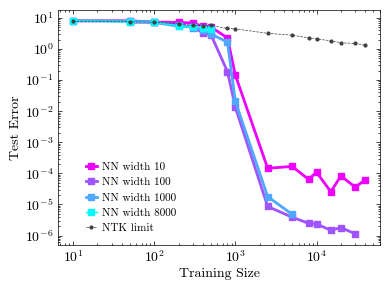

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None  # Added custom label field

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    greyblack='#404040'
    
    def __init__(self):
        self.setup_science_style()
        
        # Define default color schemes
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'greyblack': self.greyblack
        }
    
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            
            # Font settings
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            
            # Axis settings
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            
            # Tick settings
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            
            # Grid settings
            'grid.linewidth': 0.5,
            
            # Line settings
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            
            # Legend settings
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_training_curves(self,
                           results_data: ResultsData,
                           nn_config: Dict[str, List],
                           ntk_config: Dict[str, List],
                           training_mode: str = 'ntk',
                           nn_styles: Optional[Dict[int, PlotStyle]] = None,
                           ntk_styles: Optional[Dict[int, PlotStyle]] = None,
                           figsize: Optional[Tuple[float, float]] = None,
                           legend_loc: str = 'upper right',
                           legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                           legend_fontsize: Optional[float] = None,
                           xlabel: Optional[str] = None,
                           ylabel: Optional[str] = None) -> plt.Figure:
        """
        Create training curves plot with customizable legend.
        
        Args:
            results_data: ResultsData object
            nn_config: Neural network configuration
            ntk_config: NTK configuration
            training_mode: Mode for kernel training ('ntk', 'nngp', or 'random_limit')
            nn_styles: Dict mapping widths to PlotStyle objects for NN curves
            ntk_styles: Dict mapping widths to PlotStyle objects for NTK curves
            figsize: Optional figure size
            legend_loc: Location of the legend ('upper right', 'center left', etc.)
            legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
            legend_fontsize: Font size for legend text
        """
        if figsize is None:
            figsize = (3.3, 2.5)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default styles if none provided
        default_nn_style = PlotStyle(
            color=self.colors['blue'], 
            linestyle='-', 
            linewidth=1.0,
            marker='o',
            markersize=3,
            label=None
        )
        default_ntk_style = PlotStyle(
            color=self.colors['purple'], 
            linestyle='-', 
            linewidth=1.0, 
            marker='o', 
            markersize=3,
            label=None
        )
        
        # Plot NN results
        for depth in nn_config['depths']:
            for width in nn_config['widths']:
                style = nn_styles.get(width, default_nn_style) if nn_styles else default_nn_style
                
                for lr in nn_config['learning_rates']:
                    results = results_data.filter_results(
                        'nn', depth=depth, hidden_size=width, learning_rate=lr
                    )
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        
                        # Use custom label if provided, otherwise use default
                        label = style.label if style.label is not None else f'NN d={depth},h={width}'
                        
                        ax.plot(train_sizes, errors, 
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Plot NTK results
        for depth in ntk_config['depths']:
            for width in ntk_config['widths']:
                style = ntk_styles.get(width, default_ntk_style) if ntk_styles else default_ntk_style
                
                results = [r for r in results_data.filter_results('ntk', depth=depth, hidden_size=width)
                          if r.get('training_mode') == training_mode]
                
                if results:
                    sorted_results = sorted(results, key=lambda x: x['n_train'])
                    train_sizes = [r['n_train'] for r in sorted_results]
                    errors = [r['test_error'] for r in sorted_results]
                    
                    # Use custom label if provided, otherwise use default
                    label = style.label if style.label is not None else f'NTK d={depth},h={width}'
                    
                    ax.plot(train_sizes, errors,
                           color=style.color,
                           linestyle=style.linestyle,
                           linewidth=style.linewidth,
                           marker=style.marker,
                           markersize=style.markersize,
                           alpha=style.alpha,
                           label=label)
        
        # Configure log axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else 'Training Size', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else 'Test Error', labelpad=2)
        
        # Add legend with customizable position and size
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.0,
            'handletextpad': 0.5
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
            
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        
        plt.tight_layout()
        return fig


def create_training_plot(
    results_data,
    nn_config: dict,
    ntk_config: dict,
    nn_styles: dict,
    ntk_styles: dict,
    training_mode: str = 'ntk',
    figsize: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'upper right',
    legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
    legend_fontsize: Optional[float] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None
):
    """
    Create a training plot with specified configurations and styles.
    
    Args:
        results_data: The loaded results data
        nn_config: Configuration for neural networks
        ntk_config: Configuration for NTK
        nn_styles: Dictionary mapping widths to PlotStyle objects for NN
        ntk_styles: Dictionary mapping widths to PlotStyle objects for NTK
        training_mode: Which kernel training mode to use
        figsize: Optional figure size
        legend_loc: Location of the legend
        legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
        legend_fontsize: Font size for legend text
    """
    plotter = SciencePlotter()
    
    # Create the plot
    fig = plotter.plot_training_curves(
        results_data,
        nn_config=nn_config,
        ntk_config=ntk_config,
        training_mode=training_mode,
        nn_styles=nn_styles,
        ntk_styles=ntk_styles,
        figsize=figsize,
        legend_loc=legend_loc,
        legend_bbox_to_anchor=legend_bbox_to_anchor,
        legend_fontsize=legend_fontsize,
        xlabel=xlabel if xlabel is not None else 'Training Size',
        ylabel=ylabel if ylabel is not None else 'Test Error'
    )
    
    return fig

# Usage example:
plotter = SciencePlotter()

# Define styles with custom labels
nn_styles = {
    10: PlotStyle(
        color="#ee00ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=5,
        label="NN width 10"  # Custom label
    ),
    100: PlotStyle(
        color="#9f54ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=5,
        label="NN width 100"  # Custom label
    ),
    1000: PlotStyle(
        color="#4fa7ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=5,
        label="NN width 1000"  # Custom label
    ),
    8000: PlotStyle(
        color="#00fbff",
        linestyle='-',
        linewidth=1.0,
        marker='s',
        markersize=5,
        label="NN width 8000"  # Custom label
    )
}

ntk_styles = {
    8000: PlotStyle(
        color=plotter.greyblack,
        linestyle='--',
        linewidth=0.5,
        marker='o',
        markersize=2,
        label="NTK limit"  # Custom label
    )
}

# Define configurations
nn_config = {
    'depths': [4],
    'widths': [10, 100, 1000, 8000],
    'learning_rates': [0.05]
}

ntk_config = {
    'depths': [4],
    'widths': [8000]
}

# Create plot with custom legend settings
fig = create_training_plot(
    results_data=results_data,
    nn_config=nn_config,
    ntk_config=ntk_config,
    nn_styles=nn_styles,
    ntk_styles=ntk_styles,
    training_mode='ntk',
    figsize=(4, 3),  # Larger figure size
    legend_loc='center left',  # Position legend on the left
    legend_bbox_to_anchor=(0.05, 0.2),  # Place legend outside the plot
    legend_fontsize=8  # Smaller font size for legend
)

# Save plot as both PNG and SVG
fig.savefig('training_curves.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

fig.savefig('training_curves.svg',
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

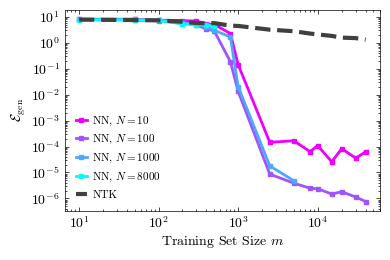

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None  # Custom label field

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    greyblack = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
        # Define default color schemes
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'greyblack': self.greyblack
        }
    
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            
            # Font settings
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            
            # Axis settings
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            
            # Tick settings
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            
            # Grid settings
            'grid.linewidth': 0.5,
            
            # Line settings
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            
            # Legend settings
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_training_curves(self,
                           results_data: ResultsData,
                           nn_config: Dict[str, List],
                           kernel_config: Dict[str, List],
                           training_modes: List[str] = ['ntk'],
                           nn_styles: Optional[Dict[int, PlotStyle]] = None,
                           kernel_styles: Optional[Dict[str, Dict[int, PlotStyle]]] = None,
                           figsize: Optional[Tuple[float, float]] = None,
                           legend_loc: str = 'upper right',
                           legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                           legend_fontsize: Optional[float] = None,
                           xlabel: Optional[str] = None,
                           ylabel: Optional[str] = None) -> plt.Figure:
        """
        Create training curves plot with customizable legend.
        
        Args:
            results_data: ResultsData object
            nn_config: Neural network configuration
            kernel_config: Kernel configuration for both NTK and NNGP
            training_modes: List of kernel training modes ('ntk', 'nngp', 'random_limit')
            nn_styles: Dict mapping widths to PlotStyle objects for NN curves
            kernel_styles: Dict mapping kernel types to width styles
            figsize: Optional figure size
            legend_loc: Location of the legend ('upper right', 'center left', etc.)
            legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
            legend_fontsize: Font size for legend text
            xlabel: Custom x-axis label
            ylabel: Custom y-axis label
        """
        if figsize is None:
            figsize = (3.3, 2.5)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for neural networks
        default_nn_style = PlotStyle(
            color=self.colors['blue'], 
            linestyle='-', 
            linewidth=1.0,
            marker='o',
            markersize=3,
            label=None
        )
        
        # Plot NN results
        for depth in nn_config['depths']:
            for width in nn_config['widths']:
                style = nn_styles.get(width, default_nn_style) if nn_styles else default_nn_style
                
                for lr in nn_config['learning_rates']:
                    results = results_data.filter_results(
                        'nn', depth=depth, hidden_size=width, learning_rate=lr
                    )
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        
                        # Use custom label if provided, otherwise use default
                        label = style.label if style.label is not None else f'NN d={depth},h={width}'
                        
                        ax.plot(train_sizes, errors, 
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Plot kernel results (NTK, NNGP, and Random Limit)
        for mode in training_modes:
            # Set default style based on kernel type
            if mode == 'ntk':
                default_color = self.colors['purple']
                default_linestyle = '--'
            elif mode == 'nngp':
                default_color = self.colors['green']
                default_linestyle = ':'
            else:  # random_limit
                default_color = self.colors['orange']
                default_linestyle = '-.'
                
            default_kernel_style = PlotStyle(
                color=default_color,
                linestyle=default_linestyle,
                linewidth=1.0,
                marker='o',
                markersize=3,
                label=None
            )
            
            for depth in kernel_config['depths']:
                for width in kernel_config['widths']:
                    style = (kernel_styles.get(mode, {}).get(width, default_kernel_style) 
                            if kernel_styles else default_kernel_style)
                    
                    results = [r for r in results_data.filter_results('kernel', depth=depth, hidden_size=width)
                              if r.get('training_mode') == mode]
                    
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        
                        # Use custom label if provided, otherwise use default
                        kernel_type = {
                            'ntk': 'NTK',
                            'nngp': 'NNGP',
                            'random_limit': 'Random'
                        }.get(mode, mode.upper())
                        label = style.label if style.label is not None else f'{kernel_type} d={depth},h={width}'
                        
                        ax.plot(train_sizes, errors,
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Configure log axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else 'Training Size', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else 'Test Error', labelpad=2)
        
        # Add legend with customizable position and size
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.0,
            'handletextpad': 0.5
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
            
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        
        plt.tight_layout()
        return fig


def create_training_plot(
    results_data,
    nn_config: dict,
    kernel_config: dict,
    nn_styles: dict,
    kernel_styles: dict,
    training_modes: List[str] = ['ntk'],
    figsize: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'upper right',
    legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
    legend_fontsize: Optional[float] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None
):
    """
    Create a training plot with specified configurations and styles.
    
    Args:
        results_data: The loaded results data
        nn_config: Configuration for neural networks
        kernel_config: Configuration for kernels (NTK/NNGP/Random)
        nn_styles: Dictionary mapping widths to PlotStyle objects for NN
        kernel_styles: Dictionary mapping kernel types to width styles
        training_modes: List of kernel modes to plot
        figsize: Optional figure size
        legend_loc: Location of the legend
        legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
        legend_fontsize: Font size for legend text
        xlabel: Custom x-axis label
        ylabel: Custom y-axis label
    """
    plotter = SciencePlotter()
    
    # Create the plot
    fig = plotter.plot_training_curves(
        results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        training_modes=training_modes,
        nn_styles=nn_styles,
        kernel_styles=kernel_styles,
        figsize=figsize,
        legend_loc=legend_loc,
        legend_bbox_to_anchor=legend_bbox_to_anchor,
        legend_fontsize=legend_fontsize,
        xlabel=xlabel,
        ylabel=ylabel
    )
    
    return fig

# Usage example:
plotter = SciencePlotter()

# Define styles for neural networks
nn_styles = {
    10: PlotStyle(
        color="#ee00ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $N=10$"
    ),
    100: PlotStyle(
        color="#9f54ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $N=100$"
    ),
    1000: PlotStyle(
        color="#4fa7ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $N=1000$"
    ),
    8000: PlotStyle(
        color="#00fbff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3,
        label=r"NN, $N=8000$"
    )
}

# Define styles for kernels (NTK, NNGP, and Random Limit)
kernel_styles = {
    'ntk': {
        8000: PlotStyle(
            color=plotter.greyblack,
            linestyle='dashed',
            linewidth=3.0,
            marker='',
            markersize=2.5,
            label="NTK"
        )
    },
    # 'nngp': {
    #     8000: PlotStyle(
    #         color=plotter.GREEN,
    #         linestyle=':',
    #         linewidth=0.5,
    #         marker='s',
    #         markersize=2,
    #         label="NNGP limit"
    #     )
    # },
    # #'random_limit': {
    # #    8000: PlotStyle(
    # #        color=plotter.ORANGE,
    # #        linestyle='-.',
    # #        linewidth=0.5,
    # #        marker='^',
    # #        markersize=2,
    # #        label="Random limit"
    # #    )
    # #}
}

# Define configurations
nn_config = {
    'depths': [4],
    'widths': [10, 100, 1000, 8000],
    'learning_rates': [0.05]
}

kernel_config = {
    'depths': [4],
    'widths': [8000]
}

# Create plot with all kernel types
fig = create_training_plot(
    results_data=results_data,
    nn_config=nn_config,
    kernel_config=kernel_config,
    nn_styles=nn_styles,
    kernel_styles=kernel_styles,
    training_modes=['ntk'],  # Include all three kernel types ['ntk', 'nngp', 'random_limit']
    figsize=(4, 2.7),
    legend_loc='lower left',
    legend_fontsize=8,
    xlabel=r'Training Set Size $m$',
    ylabel=r'$\mathcal{E}_{\mathrm{gen}}$'
)

# Save plot as both PNG and SVG
fig.savefig('training_curves.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

fig.savefig('training_curves.svg',
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

In [ ]:
### width

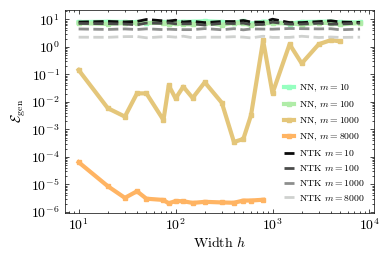

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    greyblack = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'greyblack': self.greyblack
        }
    
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def get_available_widths(self, results_data, result_type: str) -> List[int]:
        """Extract all unique hidden sizes (widths) from the results."""
        widths = set()
        results = results_data.filter_results(result_type)
        for r in results:
            if 'hidden_size' in r:
                widths.add(r['hidden_size'])
        return sorted(list(widths))

    def plot_width_curves(self,
                         results_data,
                         nn_config: Dict[str, List],
                         kernel_config: Dict[str, List],
                         training_modes: List[str] = ['ntk'],
                         nn_styles: Optional[Dict[int, PlotStyle]] = None,
                         kernel_styles: Optional[Dict[str, Dict[int, PlotStyle]]] = None,
                         figsize: Optional[Tuple[float, float]] = None,
                         legend_loc: str = 'upper right',
                         legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                         legend_fontsize: Optional[float] = None,
                         xlabel: Optional[str] = None,
                         ylabel: Optional[str] = None) -> plt.Figure:
        """Create width curves plot with customizable styles."""
        if figsize is None:
            figsize = (3.3, 2.5)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for neural networks
        default_nn_style = PlotStyle(
            color=self.colors['blue'],
            linestyle='-',
            linewidth=2.0,
            marker='s',
            markersize=3,
            alpha=1.0
        )
        
        # Plot NN results
        for depth in nn_config['depths']:
            for n_train in nn_config['n_train']:
                for lr in nn_config['learning_rates']:
                    results = results_data.filter_results(
                        'nn', depth=depth, n_train=n_train, learning_rate=lr
                    )
                    if results:
                        style = nn_styles.get(n_train, default_nn_style) if nn_styles else default_nn_style
                        
                        # Group by width and get test errors
                        width_errors = {}
                        for r in results:
                            width = r['hidden_size']
                            if width not in width_errors:
                                width_errors[width] = r['test_error']
                        
                        if width_errors:
                            widths, errors = zip(*sorted(width_errors.items()))
                            
                            label = style.label if style.label is not None else f'NN, n={n_train}'
                            ax.plot(widths, errors,
                                   color=style.color,
                                   linestyle=style.linestyle,
                                   linewidth=style.linewidth,
                                   marker=style.marker,
                                   markersize=style.markersize,
                                   alpha=style.alpha,
                                   label=label)
        
        # Plot kernel results
        for mode in training_modes:
            if mode == 'ntk':
                default_kernel_style = PlotStyle(
                    color=self.colors['greyblack'],
                    linestyle='--',
                    linewidth=2.0,
                    alpha=0.7
                )
            else:
                continue  # Skip other modes for now
            
            for depth in kernel_config['depths']:
                for n_train in nn_config['n_train']:  # Use same training sizes as NN
                    results = [r for r in results_data.filter_results('kernel', depth=depth)
                             if r.get('training_mode') == mode and r.get('n_train') == n_train]
                    
                    if results:
                        style = (kernel_styles.get(mode, {}).get(n_train, default_kernel_style) 
                                if kernel_styles else default_kernel_style)
                        
                        # Group by width and get test errors
                        width_errors = {}
                        for r in results:
                            width = r['hidden_size']
                            if width not in width_errors:
                                width_errors[width] = r['test_error']
                        
                        if width_errors:
                            widths, errors = zip(*sorted(width_errors.items()))
                            
                            label = style.label if style.label is not None else f'NTK m={n_train}'
                            ax.plot(widths, errors,
                                   color=style.color,
                                   linestyle=style.linestyle,
                                   linewidth=style.linewidth,
                                   marker=style.marker,
                                   markersize=style.markersize,
                                   alpha=style.alpha,
                                   label=label)
        
        # Configure log axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else r'Width $h$', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else r'$\mathcal{E}_{\mathrm{gen}}$', labelpad=2)
        
        # Add text box with depth and learning rate
        # ax.text(0.05, 0.95, 
        #         f'd={nn_config["depths"][0]}\n' + r'lr=5.0e-2',
        #         transform=ax.transAxes,
        #         verticalalignment='top',
        #         bbox=dict(facecolor='white', alpha=0.8))
        
        # Configure legend
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.0,
            'handletextpad': 0.5
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        plt.tight_layout()
        return fig


def create_width_plot(
    results_data,
    nn_config: dict,
    kernel_config: dict,
    nn_styles: dict,
    kernel_styles: dict,
    training_modes: List[str] = ['ntk'],
    figsize: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'upper right',
    legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
    legend_fontsize: Optional[float] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None
):
    plotter = SciencePlotter()
    
    fig = plotter.plot_width_curves(
        results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        training_modes=training_modes,
        nn_styles=nn_styles,
        kernel_styles=kernel_styles,
        figsize=figsize,
        legend_loc=legend_loc,
        legend_bbox_to_anchor=legend_bbox_to_anchor,
        legend_fontsize=legend_fontsize,
        xlabel=xlabel,
        ylabel=ylabel
    )
    
    return fig

# Example usage:
if __name__ == "__main__":
    # First get all available widths from the data
    plotter = SciencePlotter()
    
    nn_styles = {
        10: PlotStyle(
            color="#96ffc0",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=10$"
        ),
        100: PlotStyle(
            color="#b0eca8",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=100$"
        ),
        500: PlotStyle(
            color="#cad991",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=500$"
        ),
        1000: PlotStyle(
            color="#e4c67a",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=1000$"
        ),
        8000: PlotStyle(
            color="#ffb463",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=8000$"
        )
    }

    kernel_styles = {
        'ntk': {
            10: PlotStyle(
                color='#0a0a0a',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=10$"
            ),
            100: PlotStyle(
                color='#4b4c4b',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=100$"
            ),
            1000: PlotStyle(
                color='#8d8e8d',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=1000$"
            ),
            8000: PlotStyle(
                color='#cfd1cf',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=8000$"
            )
        }
    }

    nn_config = {
        'depths': [4],
        'n_train': [10,100, 1000, 8000],  # Different training sizes
        'learning_rates': [0.05]
    }

    kernel_config = {
        'depths': [4],
        'n_train': [10,100, 1000, 8000]  # Match NN training sizes
    }

    # Create plot
    fig = create_width_plot(
        results_data=results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        nn_styles=nn_styles,
        kernel_styles=kernel_styles,
        training_modes=['ntk'],
        figsize=(4, 2.7),
        legend_loc='lower right',
        legend_fontsize=7,
        xlabel=r'Width $N$',
        ylabel=r'$\mathcal{E}_{\mathrm{gen}}$'
    )

    # Save plot as both PNG and SVG
    fig.savefig('width_analysis.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

    fig.savefig('width_analysis.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

In [ ]:
## threshold

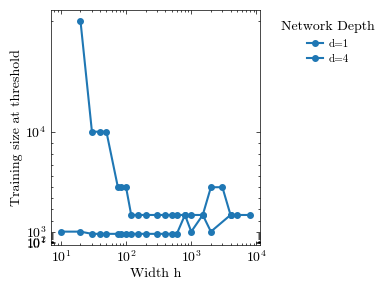

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    greyblack = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'greyblack': self.greyblack
        }
        
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax, x_only=False):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        if not x_only:
            ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_threshold_curves(self,
                            results_data,
                            nn_config: Dict[str, List],
                            kernel_config: Dict[str, List],
                            performance_threshold: float = 80.0,
                            depth_styles: Optional[Dict[int, PlotStyle]] = None,
                            figsize: Optional[Tuple[float, float]] = None,
                            legend_loc: str = 'upper left',
                            legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                            legend_fontsize: Optional[float] = None,
                            xlabel: Optional[str] = None,
                            ylabel: Optional[str] = None) -> plt.Figure:
        """Create threshold crossing analysis plot with customizable styles."""
        if figsize is None:
            figsize = (4, 3)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for depths
        default_depth_styles = {
            depth: PlotStyle(
                color='#1f77b4',  # blue
                linestyle='-',
                linewidth=1.5,
                marker='o',
                markersize=4,
                alpha=1.0,
                label=f'd={depth}'
            )
            for depth in nn_config['depths']
        }
        
        # Get all available widths from the data if not provided
        if 'width_range' not in nn_config:
            all_widths = set()
            for result in results_data.filter_results('nn'):
                if 'hidden_size' in result:
                    all_widths.add(result['hidden_size'])
            nn_config['width_range'] = sorted(list(all_widths))
        
        # Plot threshold data for each depth
        for depth in nn_config['depths']:
            threshold_data = []  # Store (hidden_size, crossing_point) pairs
            
            for hidden_size in nn_config['width_range']:
                # Get NTK results for this configuration
                ntk_errors_dict = {}
                ntk_results = results_data.filter_results('kernel', depth=depth, hidden_size=hidden_size)
                for r in ntk_results:
                    if r.get('training_mode') == 'ntk' and r.get('status') == 'success':
                        ntk_errors_dict[r['n_train']] = r['test_error']
                
                # Get NN results
                nn_results = results_data.filter_results(
                    'nn', depth=depth, hidden_size=hidden_size, learning_rate=nn_config['learning_rates'][0]
                )
                
                if nn_results:
                    # Sort by training size
                    nn_points = sorted([(r['n_train'], r['test_error']) for r in nn_results])
                    
                    # Find first threshold crossing
                    for train_size, nn_error in nn_points:
                        ntk_error = ntk_errors_dict.get(train_size)
                        if ntk_error is not None:
                            if nn_error <= ntk_error * (100 - performance_threshold) / 100:
                                threshold_data.append((hidden_size, train_size))
                                break
            
            if threshold_data:
                style = depth_styles.get(depth, default_depth_styles[depth]) if depth_styles else default_depth_styles[depth]
                hidden_widths, crossing_points = zip(*sorted(threshold_data))
                
                ax.plot(hidden_widths, crossing_points,
                       color=style.color,
                       linestyle=style.linestyle,
                       linewidth=style.linewidth,
                       marker=style.marker,
                       markersize=style.markersize,
                       alpha=style.alpha,
                       label=style.label)
        
        # Configure axes
        self.configure_log_axes(ax, x_only=True)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else r'Width $h$', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else r'Training size at threshold', labelpad=2)
        
        # Add text box with learning rate
        # ax.text(0.05, 0.95, 
        #         r'lr=5.0e-2',
        #         transform=ax.transAxes,
        #         verticalalignment='top',
        #         bbox=dict(facecolor='white', alpha=0.8))
        
        # Configure legend
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.5,
            'handletextpad': 0.5,
            'title': 'Network Depth'
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        plt.tight_layout()
        return fig


def create_threshold_plot(
    results_data,
    nn_config: dict,
    kernel_config: dict,
    performance_threshold: float = 80.0,
    depth_styles: Optional[Dict[int, PlotStyle]] = None,
    figsize: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'upper left',
    legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
    legend_fontsize: Optional[float] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None
):
    plotter = SciencePlotter()
    
    fig = plotter.plot_threshold_curves(
        results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        performance_threshold=performance_threshold,
        depth_styles=depth_styles,
        figsize=figsize,
        legend_loc=legend_loc,
        legend_bbox_to_anchor=legend_bbox_to_anchor,
        legend_fontsize=legend_fontsize,
        xlabel=xlabel,
        ylabel=ylabel
    )
    
    return fig

# Example usage:
if __name__ == "__main__":
    # Set up styles for single depth
    depth_styles = {
        4: PlotStyle(
            color='#1f77b4',  # blue
            linestyle='-',
            linewidth=1.5,
            marker='o',
            markersize=4,
            label='d=4'
        )
    }

    # Get all available widths from the data
    plotter = SciencePlotter()
    all_widths = set()
    for result in results_data.filter_results('nn'):
        if 'hidden_size' in result:
            all_widths.add(result['hidden_size'])
    all_widths = sorted(list(all_widths))

    # Define minimal configurations
    nn_config = {
        'depths': [1,4],  # Single depth
        'width_range': all_widths,  # All available widths
        'learning_rates': [0.05]
    }

    kernel_config = {
        'depths': [1,4]  # Same depth as NN
    }

    # Create plot
    fig = create_threshold_plot(
        results_data=results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        performance_threshold=90.0,  # Only hyperparameter needed
        depth_styles=depth_styles,
        figsize=(4, 3),
        legend_loc='upper left',
        legend_bbox_to_anchor=(1.05, 1),
        legend_fontsize=8,
        xlabel='Width h',
        ylabel='Training size at threshold'
    )

    # Save plot as both PNG and SVG
    fig.savefig('threshold_crossing.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

    fig.savefig('threshold_crossing.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

In [ ]:
#color

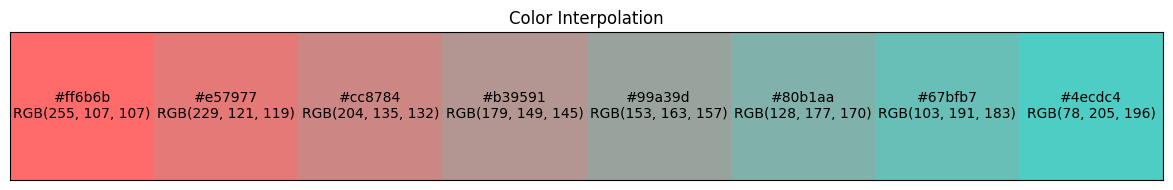


Color Information:
-----------------
Color 1: #ff6b6b RGB(255, 107, 107)
Color 2: #e57977 RGB(229, 121, 119)
Color 3: #cc8784 RGB(204, 135, 132)
Color 4: #b39591 RGB(179, 149, 145)
Color 5: #99a39d RGB(153, 163, 157)
Color 6: #80b1aa RGB(128, 177, 170)
Color 7: #67bfb7 RGB(103, 191, 183)
Color 8: #4ecdc4 RGB(78, 205, 196)


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def interpolate_colors(color1, color2, steps):
    # Convert hex to RGB
    def hex_to_rgb(hex_color):
        hex_color = hex_color.lstrip('#')
        return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    
    # Convert RGB to hex
    def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(
            max(0, min(255, int(rgb[0]))),
            max(0, min(255, int(rgb[1]))),
            max(0, min(255, int(rgb[2])))
        )
    
    # Get RGB values for both colors
    rgb1 = hex_to_rgb(color1)
    rgb2 = hex_to_rgb(color2)
    
    # Calculate the increment for each color channel
    steps_minus_1 = max(1, steps - 1)
    rgb_step = [(rgb2[i] - rgb1[i]) / steps_minus_1 for i in range(3)]
    
    # Generate colors and their RGB values
    colors = []
    rgb_values = []
    for step in range(steps):
        new_rgb = [rgb1[i] + (rgb_step[i] * step) for i in range(3)]
        rgb_values.append(tuple(int(x) for x in new_rgb))
        colors.append(rgb_to_hex(new_rgb))
    
    return colors, rgb_values

def plot_colors(colors, rgb_values):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 2))
    
    # Create color boxes
    for i, (color, rgb) in enumerate(zip(colors, rgb_values)):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=color))
        # Add hex code and RGB values
        text = f"{color}\nRGB{rgb}"
        ax.text(i + 0.5, 0.5, text, 
                horizontalalignment='center',
                verticalalignment='center',
                rotation=90 if len(colors) > 10 else 0)
    
    # Set the axis limits and aspect ratio
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set title
    plt.title('Color Interpolation')
    plt.tight_layout()
    plt.show()

    # Print color information
    print("\nColor Information:")
    print("-----------------")
    for i, (color, rgb) in enumerate(zip(colors, rgb_values)):
        print(f"Color {i+1}: {color} RGB{rgb}")

# Example usage:
start_color = "#FF6B6B"  # Red
end_color = "#4ECDC4"    # Blue
number_of_points = 8

colors, rgb_values = interpolate_colors(start_color, end_color, number_of_points)
plot_colors(colors, rgb_values)